In [1]:
from __future__ import absolute_import, division, print_function

import IPython
import numpy as np
import base64
import matplotlib.pyplot as plt

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

2022-03-27 11:43:38.529855: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-27 11:43:38.529906: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
num_iterations = 5000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 1000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

In [3]:
env_name = 'Taxi-v3'
env = suite_gym.load(env_name)
env.reset()

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array(162),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})

In [4]:
#env.render()

In [5]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='observation', minimum=0, maximum=499)


In [6]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [7]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=5)


In [8]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array(169),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})
Next time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array(69),
 'reward': array(-1., dtype=float32),
 'step_type': array(1, dtype=int32)})


In [9]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

In [10]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [11]:
#fc_layer_params = (10, 10, 50, 50, )
fc_layer_params = (100, )
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)


In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)


2022-03-27 11:43:55.610390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-27 11:43:55.610591: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-27 11:43:55.610638: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-27 11:43:55.610714: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-27 11:43:55.610788: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [13]:
agent.initialize()

In [14]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [15]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [16]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

In [17]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

-774.1

In [18]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

In [19]:
print(agent.collect_data_spec)
print(agent.collect_data_spec._fields)


Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(5)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(), dtype=tf.int64, name='observation', minimum=array(0), maximum=array(499)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})
('step_type', 'observation', 'action', 'policy_info', 'next_step_type', 'reward', 'discount')


In [20]:
def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  # Do not use the below. It use tensor objects which cause error
  # next_time_step = environment.step(action_step.action)
  # For step argument, we put numpy object as action integer like below
  next_time_step = environment.step(action_step.action.numpy()[0])
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

In [21]:
def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)


In [22]:
collect_data(train_env, random_policy, replay_buffer, steps=100)


In [23]:
replay_buffer

In [24]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [25]:
dataset

<PrefetchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'policy_info': (),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)}), BufferInfo(ids=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), probabilities=TensorSpec(shape=(64,), dtype=tf.float32, name=None)))>

In [26]:
iterator = iter(dataset)
print(iterator)

In [27]:
iterator.next()

(Trajectory(
 {'action': <tf.Tensor: shape=(64, 2), dtype=int64, numpy=
 array([[1, 3],
        [3, 5],
        [1, 3],
        [3, 3],
        [2, 0],
        [4, 4],
        [3, 3],
        [4, 0],
        [0, 1],
        [3, 3],
        [3, 1],
        [3, 3],
        [2, 0],
        [5, 5],
        [3, 2],
        [2, 3],
        [4, 2],
        [2, 3],
        [5, 2],
        [3, 3],
        [0, 2],
        [3, 2],
        [4, 3],
        [4, 0],
        [4, 3],
        [0, 2],
        [5, 1],
        [3, 2],
        [4, 5],
        [0, 5],
        [5, 0],
        [4, 4],
        [3, 2],
        [0, 1],
        [4, 0],
        [1, 5],
        [5, 5],
        [1, 5],
        [2, 2],
        [4, 4],
        [5, 2],
        [3, 2],
        [2, 0],
        [5, 1],
        [0, 4],
        [2, 4],
        [2, 2],
        [4, 0],
        [0, 4],
        [2, 4],
        [5, 2],
        [1, 4],
        [4, 0],
        [5, 4],
        [4, 0],
        [0, 0],
        [4, 3],
        [5, 0],


In [28]:
agent.train = common.function(agent.train)

In [29]:
agent.train_step_counter.assign(0)

<tf.Variable 'UnreadVariable' shape=() dtype=int32, numpy=0>

In [30]:
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

In [31]:
for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy, replay_buffer)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience)

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 200: loss = 961425.1875
step = 400: loss = 394212.5625
step = 600: loss = 815675.0625
step = 800: loss = 2376271.75
step = 1000: loss = 19997454.0
step = 1000: Average Return = -200.0
step = 1200: loss = 3653193.0
step = 1400: loss = 1619591.25
step = 1600: loss = 1915248.375
step = 1800: loss = 2476783.0
step = 2000: loss = 3105739.75
step = 2000: Average Return = -200.0
step = 2200: loss = 86238296.0
step = 2400: loss = 10052096.0
step = 2600: loss = 164284352.0
step = 2800: loss = 16992938.0
step = 3000: loss = 16503592.0
step = 3000: Average Return = -200.0
step = 3200: loss = 2898768.5
step = 3400: loss = 37020188.0
step = 3600: loss = 14924718.0
step = 3800: loss = 35867040.0
step = 4000: loss = 26263100.0
step = 4000: Average Return = -200.0


(-2090.0, 250.0)

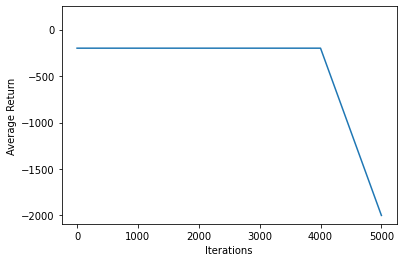

In [32]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

In [38]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [39]:
import imageio

def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

In [40]:
create_policy_eval_video(agent.policy, "trained-agent")

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



KeyboardInterrupt: 